In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os

from tqdm import tqdm
from compression.api import DataLoader, Metric

In [2]:
IMAGE_WIDTH = 1600
IMAGE_HEIGHT = 800
DEVICE='cuda'

In [3]:
def post_processing(mask, fill_poly=False):
    # Convert the network result to a segmentation map and display the result.
    outputs = np.reshape(mask, (IMAGE_HEIGHT, IMAGE_WIDTH, 1)).round()
    
    if fill_poly:
        image = cv2.convertScaleAbs(outputs, alpha=(255.0))
        contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        ## Fill hole
        for idx in range(len(contours)):
            contour = contours[idx]
            area = cv2.contourArea(contour)
            cv2.fillPoly(image, pts =[contour], color=(255,255,255))
        
        contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        ## Erase Edge
        kernel = np.ones((3,3), np.uint8)
        outputs = cv2.erode(image, kernel, iterations = 2) / 255
        outputs = np.resize(outputs, (IMAGE_HEIGHT, IMAGE_WIDTH, 1))
    
    return outputs

In [4]:
def normalize(image: np.ndarray, input_range=[0, 1], mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) -> np.ndarray:
    image = image.astype(np.float32)
    if input_range is not None:
        mean = np.array(mean)
        image = image - mean

    if std is not None:
        std = np.array(std)
        image = image / 255 / std
    return image

In [5]:
class STASDataset(DataLoader):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # if image.shape != (800, 800, 3):
        #     image = cv2.resize(image, (1600, 800), interpolation=cv2.INTER_LANCZOS4)
        
        mask = cv2.imread(self.masks_fps[i], 0)
        if mask.shape != (800, 800, 3):
            mask = cv2.resize(mask, (1600, 800), interpolation=cv2.INTER_LANCZOS4)  
        mask = mask.astype('bool')
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # image = normalize(image)
        
        return image, mask
        
    def __len__(self):
        return len(self.ids)

(942, 1716, 3)
(800, 1600, 1)


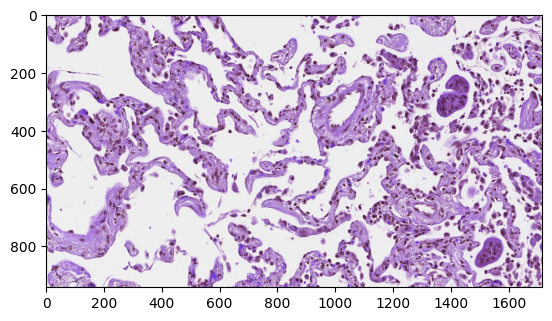

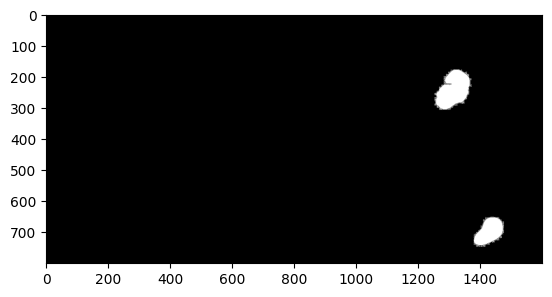

In [6]:
import config as cfg

data_loader = STASDataset(cfg.VALID_IMAGE_DIR, cfg.VALID_LABEL_DIR, classes=['stas'])
image, mask = next(item for item in data_loader)
print(image.shape)
print(mask.shape)
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(mask, cmap="gray")

# PyTorch Accuracy Check

In [7]:
import segmentation_models_pytorch as smp
from collections import OrderedDict
import torch

import config as cfg

In [8]:
def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    normalized_image = normalize(resized_image)

    # Convert the resized images to network input shape.
    # input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0).astype(float)
    normalized_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0).astype(float)
    
    x_tensor = torch.from_numpy(normalized_image).to('cpu')
    
    return x_tensor

In [9]:
def torch_inference(best_model, x_tensor):
    # best_model.eval()
    # x_tensor = torch.from_numpy(normalized_image).to('cpu')
    
    with torch.no_grad():
        pr_mask = best_model(x_tensor.float())
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    mask = post_processing(pr_mask, fill_poly=True)
    # mask = np.reshape(pr_mask, (IMAGE_HEIGHT, IMAGE_WIDTH, 1))    
    return mask

In [10]:

def accuracy_checker(model, use_torch=False):
    y_true, y_pred, correct_true = 0, 0, 0

    for batch in tqdm(data_loader):
        img, label = batch
        if use_torch:
            # norm_img = preprocessing(img)
            norm_img = preprocess(img)
            outputs = torch_inference(model, norm_img)
        else:
            input_tensor = create_input_tensor(img)
            probs = ppp_inference(model, input_tensor)
            outputs = post_processing(probs, fill_poly=True)
        
        correct_true += np.sum(
                (label == outputs).astype(np.byte) * (label == 1).astype(np.byte)
            ).astype(np.float32)
        
        y_true += np.sum(label)
        y_pred += np.sum(outputs)

    recall = correct_true / y_pred
    precision = correct_true / y_true

    f1 = (2 * precision * recall) / (precision + recall)
    print(f"F1 Score: {f1}")

In [11]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'


model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

state_dict = torch.load(os.path.join(cfg.MODEL_DIR, "Deeplabv3P_resnet50_batch16.pth"), map_location='cpu')
torch_model = state_dict.module
torch_model.eval()

# mask = torch_inference(best_model, normalized_image)
# plt.figure()
# plt.imshow(mask, cmap="gray")

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [12]:
accuracy_checker(torch_model, use_torch=True)

100%|██████████| 120/120 [06:47<00:00,  3.40s/it]

F1 Score: 0.8898716608160928


# OpenVINO Accuracy Check

In [13]:
from openvino.runtime import Core
from openvino.preprocess import PrePostProcessor, ResizeAlgorithm, ColorFormat
from openvino.runtime import Core, Layout, Type, Output

In [14]:
def load_ir_model(data_type):
    OUTPUT_PATH = "./Deeplabv3P_resnet50_batch16"
    DATA_TYPE = data_type
    BASE_MODEL_NAME = OUTPUT_PATH + "/" + DATA_TYPE.lower() + "/" + DATA_TYPE


    # Paths where PyTorch, ONNX and OpenVINO IR models will be stored.
    model_path = Path(BASE_MODEL_NAME).with_suffix(".pth")
    onnx_path = model_path.with_suffix(".onnx")
    ir_path = model_path.with_suffix(".xml")

    print(f"ONNX model: {onnx_path}")
    print(f"Optimized model: {ir_path}")
    return onnx_path, ir_path

In [15]:
def build_prepostprocessor(model, h=942, w=1716):
    ppp = PrePostProcessor(model)
    # h, w = 942, 1716

    ppp.input().tensor().set_layout(Layout('NHWC')).set_spatial_static_shape(h, w).set_color_format(ColorFormat.BGR)
    ppp.input().preprocess().convert_color(ColorFormat.RGB).resize(ResizeAlgorithm.RESIZE_LINEAR, IMAGE_HEIGHT, IMAGE_WIDTH).\
                            mean([0.485, 0.456, 0.406]).scale([255 * 0.229, 255 * 0.224, 255 * 0.225])

    ppp.input().model().set_layout(Layout('NCHW'))
    ppp.output().tensor().set_element_type(Type.f32)

    model = ppp.build()
    compiled_model = ie.compile_model(model, 'AUTO')
    return compiled_model

In [16]:
def ppp_inference(compiled_model, input_tensor):
    
    results = compiled_model.infer_new_request({0: input_tensor})
    probs = next(iter(results.values()))
    return probs

In [17]:
def create_input_tensor(image):
    input_tensor = np.expand_dims(image, 0)
    return input_tensor

In [18]:
def load_image(filename = "Private_00000045.jpg"):
    image_filename = os.path.join(cfg.INFERENCE_IMAGE_DIR, filename)
    image = cv2.imread(image_filename)
    return image

In [19]:
ie = Core()
_, ir_path = load_ir_model(data_type="FP16")
model = ie.read_model(model=ir_path)
fp16 = build_prepostprocessor(model)

_, ir_path = load_ir_model(data_type="FP32")
model = ie.read_model(model=ir_path)
fp32 = build_prepostprocessor(model)

ONNX model: Deeplabv3P_resnet50_batch16/fp16/FP16.onnx
Optimized model: Deeplabv3P_resnet50_batch16/fp16/FP16.xml
ONNX model: Deeplabv3P_resnet50_batch16/fp32/FP32.onnx
Optimized model: Deeplabv3P_resnet50_batch16/fp32/FP32.xml


(942, 1716, 3)


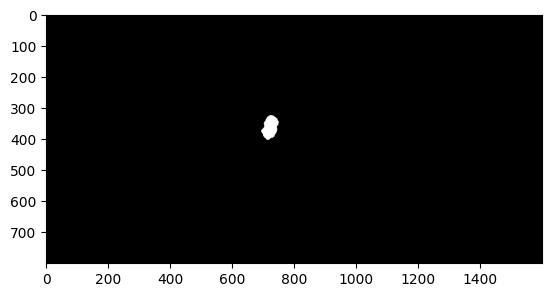

In [20]:
im = load_image(filename = "Private_00000045.jpg")
print(im.shape)
input_tensor = create_input_tensor(im)
probs = ppp_inference(fp16, input_tensor)
outputs = post_processing(probs, fill_poly=True)

plt.imshow(outputs, cmap="gray")

In [25]:
accuracy_checker(fp16)

100%|██████████| 120/120 [03:06<00:00,  1.55s/it]

F1 Score: 0.8898373734522593


In [26]:
accuracy_checker(fp32)

100%|██████████| 120/120 [03:13<00:00,  1.61s/it]

F1 Score: 0.8898373734522593
